In [2]:
from astropy.wcs import WCS
from sqlite3 import connect
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from astroquery.vizier import Vizier
import pandas as pd
import sqlite3
import numpy as np
from collections import defaultdict
from os import path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as plp

import Image_module as im

## Загрузка каталогов

In [3]:
img = im.imread('test.fits') #input("Укажите название снимка или путь к нему:\n")
im_db_path = 'test.db' #input("Укажите каталог снимка или путь к нему:\n")
cat_db_path = 'catalogs.db' 
cat_name = 'ps' #input("Выберите каталог для кросс-сопоставления: ps/sdss\n")
obs_name = 'Maidanak' #input("Выберите название обсерватории")
eps = 1.5 #input("Введите значение epsilon")


w = WCS(img.hdr)

field_center = SkyCoord(*w.wcs.crval, unit = [u.deg, u.deg])
region_width = img.width * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[0]
region_height = img.height * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[1]

Каталог снимка

In [4]:
if not path.isfile(im_db_path):
        raise IOError(f"No such file \"{im_db_path}\"")
        
con1 = sqlite3.connect(im_db_path)
df1 = pd.read_sql_query("SELECT * from objects", con1)[['ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']]

df1.rename(columns={df1.columns[0]: 'RA1',
                    df1.columns[1]: 'e_RA1',
                    df1.columns[2]: 'DE1',
                    df1.columns[3]: 'e_DE1',
                    df1.columns[4]: 'r1',
                    df1.columns[5]: 'e_r1'}, inplace=True)

df1['r1'] += 0.21 # R to r magnitude transformation

Внешний каталог

In [5]:
%%time

if not path.isfile(cat_db_path):
        raise IOError(f"No such file \"{cat_db_path}\"")
        
con2 = sqlite3.connect(cat_db_path)

df2 = pd.read_sql_query("SELECT * FROM {} WHERE ({} BETWEEN ? AND ?) AND ({} BETWEEN ? AND ?)".format(cat_name, cat_name + '_RA',cat_name + '_DE'),
                        con2,
                        params = [field_center.ra.value - region_width.value/7200 - 30/3600,
                                  field_center.ra.value + region_width.value/7200 + 30/3600,
                                  field_center.dec.value - region_height.value/7200 - 30/3600,
                                  field_center.dec.value + region_height.value/7200 + 30/3600])

if cat_name == 'ps':  
    
    df2.rename(columns={df2.columns[1]: 'RA2',
                    df2.columns[2]: 'e_RA2',
                    df2.columns[3]: 'DE2',
                    df2.columns[4]: 'e_DE2',
                    df2.columns[5]: 'g2',
                    df2.columns[6]: 'e_g2',
                    df2.columns[7]: 'r2',
                    df2.columns[8]: 'e_r2',
                    df2.columns[9]: 'i2',
                    df2.columns[10]: 'e_i2',
                    df2.columns[11]: 'z2',
                    df2.columns[12]: 'e_z2',
                    df2.columns[13]: 'y2',
                    df2.columns[14]: 'e_y2'}, inplace=True)
else:
    pass

if cat_name == 'sdss':
    
    df2.rename(columns={df2.columns[1]: 'RA2',
                    df2.columns[2]: 'e_RA2',
                    df2.columns[3]: 'DE2',
                    df2.columns[4]: 'e_DE2',
                    df2.columns[5]: 'u2',
                    df2.columns[6]: 'e_u2',
                    df2.columns[7]: 'g2',
                    df2.columns[8]: 'e_g2',
                    df2.columns[9]: 'r2',
                    df2.columns[10]: 'e_r2',
                    df2.columns[11]: 'i2',
                    df2.columns[12]: 'e_i2',
                    df2.columns[13]: 'z2',
                    df2.columns[14]: 'e_z2'}, inplace=True)
else:
    pass

Wall time: 273 ms


In [6]:
loc1 = df2[['RA2', 'e_RA2', 'DE2', 'e_DE2', 'r2', 'e_r2']].dropna() #отсеим объекты без данных о блеске в r фильтре

## Про выборку

С целью создания модели классификации пар объектов по данным о магнитудах в фильтре r, создадим обучающую выборку, представленную двумя классами: первый - верно сопоставленные объекты, второй класс сформируем, устанавливая заведомо неверные сопоставления. Для формирования первого класса отберём пары "объект с изображения (далее - объект "1") == объект из внешнего каталога (далее - объект "2")", где для объекта 1 в радиусе 1 угл. сек. нашёлся единственный объект 2 и притом сопоставление взаимно однозначно (объекту 2 больше не оказался сопоставлен ни один объект 1). Второй класс сформируем выбирая  объект 1 случайно, и также случайно сопоставляя ему объект 2 из внешнего каталога

In [7]:
coords1 = SkyCoord(df1.iloc[:, 0].values.astype(float), df1.iloc[:, 2].values.astype(float), unit = [u.deg]*2)
coords2 = SkyCoord(loc1.iloc[:, 0].values.astype(float), loc1.iloc[:, 2].values.astype(float), unit = [u.deg]*2)
seplim = 1*u.arcsec
res = search_around_sky(coords1, coords2, seplimit = seplim)

In [8]:
u, c = np.unique(res[0], return_counts = True)
print("{} объектa/ов со снимка имеют более одного соседа в радиусе {} угл.сек.".format(np.count_nonzero(1*(c > 1)), seplim.value, ))

76 объектa/ов со снимка имеют более одного соседа в радиусе 1.0 угл.сек.


Первый класс

In [9]:
a1 = df1.iloc[res[0]]
a1.reset_index(inplace = True, drop=True)

a2 = loc1.iloc[res[1]]
a2.reset_index(inplace = True, drop=True)

class1 = pd.concat([a1, a2], axis = 1)
class1['match'] = 1

# взаимно-однозначное соответствие
class1.drop(index = class1.loc[class1['RA1'].duplicated()].index, inplace = True) 
class1.drop(index = class1.loc[class1['RA2'].duplicated()].index, inplace = True)

Смотр первого класса

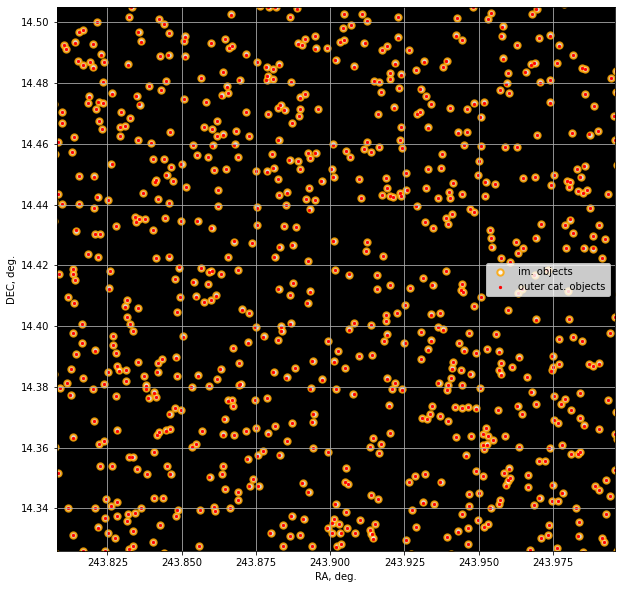

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(class1['RA1'].values.astype(float), class1['DE1'].values.astype(float), s=40, c='w', label='im. objects', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   alpha=0.85,)

ax.scatter(class1['RA2'].values.astype(float), class1['DE2'].values.astype(float), s=5, color='r', label='outer cat. objects')


ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.grid()
plt.legend()

marg=0.2
ax.margins(-marg, -marg)

Второй класс

In [11]:
r1 = np.random.randint(0, len(df1), len(class1)+1)
r2 = np.random.randint(0, len(loc1), len(class1)+1)

b1 = df1.iloc[r1]
b1.reset_index(inplace = True, drop=True)

b2 = loc1.iloc[r2]
b2.reset_index(inplace = True, drop=True)

class2 = pd.concat([b1, b2], axis = 1)
class2['match'] = 0

Проверка

In [12]:
import lamy
from importlib import reload
lamy = reload(lamy)

sep1 = class1.apply(lamy.separation, axis = 1)
sep2 = class2.apply(lamy.separation, axis = 1)

Text(0.5, 0.98, 'Распределение угловых расстояний в сопоставленных парах двух классов')

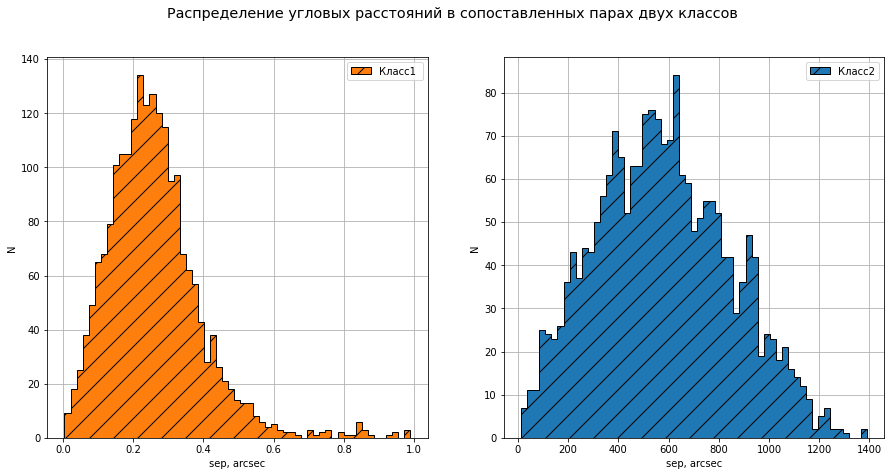

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))

k1,k2,k3=ax1.hist(sep1, histtype='step', bins=57, label='Класс1 ', color='C1', hatch='/', edgecolor='k', fill=True)
l1,l2,l3=ax2.hist(sep2, histtype='step', bins=57, label='Класс2', hatch='/', edgecolor='k', fill=True)

ax1.grid()
ax2.grid()

ax1.set_xlabel('sep, arcsec')
ax1.set_ylabel('N')

ax2.set_xlabel('sep, arcsec')
ax2.set_ylabel('N')

ax1.legend()
ax2.legend()

fig.suptitle('Распределение угловых расстояний в сопоставленных парах двух классов', fontsize="x-large")
# plt.xlim(-1,150)

In [14]:
data = pd.concat([class1[['r1', 'e_r1', 'r2', 'e_r2', 'match']], class2[['r1', 'e_r1', 'r2', 'e_r2', 'match']]])

## Модель

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import svm
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix, fbeta_score

In [47]:
X_i=np.array((data['r1'], data['e_r1'], data['r2'], data['e_r2'])).T
Y_i=np.array((data['match']))

Y=np.reshape(Y_i, (len(Y_i), 1))

sc = StandardScaler()
sc.fit(X_i)
X_i_scaled=sc.transform(X_i)

Двумерная визуализация разделимости классов с UMAP

In [60]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X_i)
umap_df = pd.DataFrame(np.concatenate((embedding, Y), axis=1), columns=['component1', 'component2', 'target'])

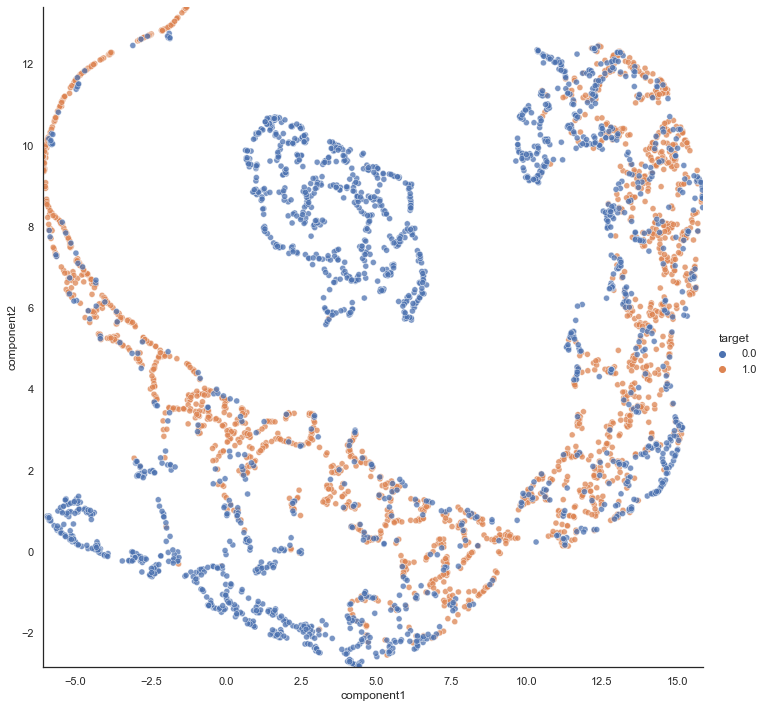

In [61]:
sns.set(rc = {'figure.figsize':(25,18)})
sns.set_theme(style="white")
sns.relplot(x="component1", y="component2", alpha=.75, hue="target", data=umap_df, height=10)
# plt.ylim(-7, 7)
# plt.xlim(-5, 5)

marg=0
plt.margins(-marg, -marg)

Учимся

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X_i, Y, test_size=.25, random_state=43)

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

ml_svm = svm.SVC(kernel='rbf', probability=True) 
# knn = KNeighborsClassifier()
# logreg=LogisticRegression()

fbeta_scorer = make_scorer(fbeta_score, beta=.5, pos_label=1)

In [64]:
# search_space_poly = {'C': [0.1, 1, 10],
#               'kernel': ['poly'],
#               'gamma': [0.1, 1, 10],
#               'degree': [3]} 

# search_space_knn = {'n_neighbors': list(range(1, 6)),
#                  'weights': ['uniform', 'distance'],
#                  'metric': ['minkowski','euclidean', 'manhattan']}

# search_space_logreg={'C': [0.0001, 0.001, 0.01, 0.1, 1],
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#               'penalty': ['l1', 'l2', 'elasticnet'],}

In [65]:
search_space_rbf = {'C': [0.1, 1, 10], 
              'gamma': [100, 10, 1],
              'kernel': ['rbf']} 

grid = GridSearchCV(ml_svm, search_space_rbf, refit=True, verbose = 3, cv=5, scoring=fbeta_scorer)
grid_search=grid.fit(X_i, Y_i)
print(grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.713 total time=   3.2s
[CV 2/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.774 total time=   3.3s
[CV 3/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.756 total time=   3.3s
[CV 4/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.697 total time=   3.3s
[CV 5/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.697 total time=   3.4s
[CV 1/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.812 total time=   1.6s
[CV 2/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.821 total time=   1.6s
[CV 3/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.830 total time=   1.7s
[CV 4/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.804 total time=   1.7s
[CV 5/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.841 total time=   1.7s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.782 total time=   1.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;,

In [66]:
Y_pred = grid.predict(X_test)

fbeta_score(Y_test.tolist(), Y_pred.tolist(), beta = .5)

0.9012797074954297

In [67]:
cf_matrix = confusion_matrix(Y_test.tolist(), Y_pred.tolist())
cf_matrix

array([[444,  60],
       [ 30, 493]], dtype=int64)

Ctrl+s

In [68]:
import joblib

joblib.dump(grid, obs_name + ".save") 

['Maidanak.save']